In [27]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime

In [28]:
## temp
#tickers_list = pd.read_csv("Tickers_Example.csv")
#tickers_list.loc[len(tickers_list)] = "PSTV" ## test stock
#tickers_list.loc[len(tickers_list)] = "CHYM" ## test stock
#tickers_list.loc[len(tickers_list)] = "FAKE TICKER" ## test stock

In [29]:
# Read CSV containing candidate stock codes (first column defaults to ticker)
tickers_list = pd.read_csv("Tickers_Example.csv")

valid_tickers_list = []

# Time period (for formal screening and subsequent calculations)
start = '2024-10-01'
end = '2025-09-30'

# Extremely short time window solely for “existence testing” (to prevent frequent requests to yfinance)
test_s = '2025-09-27'
test_e = '2025-09-30'


# Use the first column as the ticker source and retrieve historical data for the test period from yfinance one by one.
for t in tickers_list.iloc[:,0]:
    hist = yf.Ticker(t).history(start=test_s, end=test_e)
    # Any ticker with data during the test period is considered an “existing ticker.”
    if not hist.empty:
        valid_tickers_list.append(t)

# Monthly Minimum Trading Volume
threshold = 5000

# Minimum number of effective trading days within the month
min_trading_days = 18

more_valid_tickers_list = []

# Keep only the Volume column and normalize the index to a DatetimeIndex
for t in valid_tickers_list:
    t_tick = yf.Ticker(t)
    t_hist = t_tick.history(start=start,end=end)
    if not t_hist.empty:
        t_hist = t_hist[['Volume']]
        t_hist.index = pd.to_datetime(t_hist.index)
        # Extract the year and month to facilitate counting the number of trading days each month.
        t_hist['year'] = t_hist.index.to_series().dt.year
        t_hist['month'] = t_hist.index.to_series().dt.month
        # Count the number of trading days for each (year, month)
        trading_days_per_month = t_hist.groupby(['year', 'month']).size()
    else:
        continue
        
    # Calculate the average trading volume only for valid months
    valid_months = trading_days_per_month[min_trading_days <= trading_days_per_month].index
    t_hist = t_hist.set_index(['year', 'month']).loc[valid_months].reset_index()
    mean_volume = t_hist['Volume'].mean()
    # If the average trading volume meets the threshold, retain the ticker.
    if mean_volume > threshold:
        more_valid_tickers_list.append(t)
    else:
        continue

print(more_valid_tickers_list)


$AGN: possibly delisted; no timezone found
$CELG: possibly delisted; no timezone found
$MON: possibly delisted; no timezone found
$RTN: possibly delisted; no timezone found


['ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BB.TO', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RY.TO', 'SHOP.TO', 'T.TO', 'TD.TO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


In [30]:
# Market Cap Threshold Set
high_cap = 10000000000
low_cap = 2000000000

high_cap_tickers = []
mid_cap_tickers = []
low_cap_tickers = []

# Classify tickers by market cap
for t in more_valid_tickers_list:
    try:
        ticker = yf.Ticker(t)
        t_market_cap = ticker.info.get('marketCap')

        if t_market_cap is not None:
            if (t_market_cap > high_cap):
                high_cap_tickers.append(t)
            elif (t_market_cap < low_cap):
                low_cap_tickers.append(t)
    # yfinance occasionally times out or returns errors; skip this step directly.
    except Exception as e:
        print(f"Error processing ticker {t}: {e}")
        continue

print(high_cap_tickers)
print(mid_cap_tickers)
print(low_cap_tickers)


['ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RY.TO', 'SHOP.TO', 'T.TO', 'TD.TO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']
[]
[]


In [31]:
def calculate_beta_and_returns(stock_list, benchmark_ticker='^GSPC', start='2024-10-01', end='2025-09-30'):
    '''
    Calculate beta and returns for a stock compared to a benchmark
    '''
    stocks = []
    betas = []
    industries = []
    # Benchmark: Monthly Return (Measured on the first trading day of each month)
    market_data = yf.download(benchmark_ticker, start=start, end=end, auto_adjust=False,   progress=False)["Adj Close"]
    monthly_market_data = market_data.resample('MS').first()
    monthly_market_returns = monthly_market_data.pct_change().dropna()
    target_int = 1
    

    for t in stock_list:
         ticker = yf.Ticker(t)
        
       # def get_industry(t):
            #fast_form = ticker.fast_info.get("industry")
            
           # if fast_form not in [None, ""]:
               # return fast_ind
          #  return ticker.info.get("industry")
        # Download stock data - use the string ticker symbol 't' instead of the Ticker object
         stock_data = yf.download(t, start=start, end=end, auto_adjust=False, progress=False)["Adj Close"]
         monthly_stock_data = stock_data.resample('MS').first()
         monthly_stock_returns = monthly_stock_data.pct_change().dropna()
        
        # Make sure both series are 1-dimensional Series objects
         if isinstance(monthly_stock_returns, pd.DataFrame):
             monthly_stock_returns = monthly_stock_returns.squeeze()  # Convert DataFrame to Series if needed
        
         if isinstance(monthly_market_returns, pd.DataFrame):
             monthly_market_returns = monthly_market_returns.squeeze()  # Convert DataFrame to Series if needed
        
        # Create a DataFrame with both return series
         combined_returns = pd.DataFrame({
             'stock return': monthly_stock_returns,
             'market return': monthly_market_returns})
        
         # Drop rows with missing data
         combined_returns = combined_returns.dropna()

         # Calculate covariance matrix
         covariance_matrix = combined_returns.cov()
         benchmark_variance = combined_returns['market return'].var()
    
         # Access the covariance using the column names we defined
         stock_beta = round(covariance_matrix.loc['stock return', 'market return'] / benchmark_variance, 3)
        
         stocks.append(t)
         betas.append(stock_beta) 
         #industries.append(get_industry(t))
        
    result_df = pd.DataFrame ({
        'stock': stocks,
        'beta': betas,
        # 'industries': industries
    })
        
    # Distance from the target with β=1; the smaller the value, the closer to the market.
    result_df['difference'] = abs(result_df['beta'] - target_int)

    # Sort by proximity
    result_organized = result_df.sort_values(by='difference')
    if result_organized is not None:
        return result_organized
    else:
        return pd.DataFrame(columns=['stock', 'beta', 'difference'])


organized_high_cap = calculate_beta_and_returns(high_cap_tickers, benchmark_ticker='^GSPC', start='2024-10-01', end='2025-09-30')
organized_mid_cap = calculate_beta_and_returns(mid_cap_tickers, benchmark_ticker='^GSPC', start='2024-10-01', end='2025-09-30')
organized_low_cap = calculate_beta_and_returns(low_cap_tickers, benchmark_ticker='^GSPC', start='2024-10-01', end='2025-09-30')

print(organized_high_cap)
print(organized_mid_cap)
print(organized_low_cap)


      stock   beta  difference
32      UNP  1.016       0.016
31      UNH  1.028       0.028
33      UPS  1.030       0.030
8      BIIB  0.951       0.049
22       PG  0.936       0.064
10      BLK  0.901       0.099
11      BMY  0.869       0.131
26    RY.TO  0.854       0.146
29    TD.TO  0.833       0.167
28     T.TO  0.833       0.167
9        BK  1.169       0.169
2       ACN  1.331       0.331
19      MRK  0.586       0.414
20      PEP  0.544       0.456
4      AMZN  1.467       0.467
25     QCOM  1.468       0.468
6        BA  0.462       0.538
1       ABT  0.333       0.667
14       CL  0.325       0.675
13      CAT  1.700       0.700
21      PFE  0.258       0.742
30      TXN  1.764       0.764
17      LMT  0.189       0.811
34      USB  1.816       0.816
18       MO  0.101       0.899
16      LLY  0.050       0.950
5       AXP  2.004       1.004
7       BAC  2.005       1.005
3       AIG -0.032       1.032
24     PYPL  2.076       1.076
12        C  2.152       1.152
23      

In [32]:
def portfolio_generator(db1, db2, db3, min_target, max_target, column="ticker"):
    """
    50/30/20 weighted selection from the three different cap databases.
    Handles fallback if any database does not have enough rows, taking from the next one.

    db1, db2, db3: DataFrames
    min_target, max_target: limits
    column: name of the column to return values from
    """

    # Step 1: Validate targets
    if max_target < min_target:
        raise ValueError("max_target must be >= min_target.")

    # Step 2: Calculate how many we can actually take
    total_available = len(db1) + len(db2) + len(db3)
    target = min(max_target, total_available)

    if target < min_target:
        raise ValueError("Not enough total rows to meet min_target.")

    # Step 3: Weighted desired counts
    desired_1 = round(target * 0.50)
    desired_2 = round(target * 0.30)
    desired_3 = target - desired_1 - desired_2
    
    # Step 4: Handle fallback — db1 → db2 → db3
    if desired_1 > len(db1):
        overflow = desired_1 - len(db1)
        desired_1 = len(db1)
        desired_2 += overflow

    if desired_2 > len(db2):
        overflow = desired_2 - len(db2)
        desired_2 = len(db2)
        desired_3 += overflow

    if desired_3 > len(db3):
        desired_3 = len(db3)  # can't exceed

    # Step 5: Take rows deterministically (first N rows)
    part1 = db1.iloc[:desired_1]
    part2 = db2.iloc[:desired_2]
    part3 = db3.iloc[:desired_3]

    final_portfolio = pd.concat([part1, part2, part3])
    
    if len(final_portfolio) < min_target:
        raise ValueError("Not enough total rows across databases to meet min_target.")

    return final_portfolio

final_portfolio_stocks = portfolio_generator(organized_high_cap, organized_mid_cap, organized_low_cap, 10, 25, column="ticker")

print(final_portfolio_stocks)


    stock   beta  difference
32    UNP  1.016       0.016
31    UNH  1.028       0.028
33    UPS  1.030       0.030
8    BIIB  0.951       0.049
22     PG  0.936       0.064
10    BLK  0.901       0.099
11    BMY  0.869       0.131
26  RY.TO  0.854       0.146
29  TD.TO  0.833       0.167
28   T.TO  0.833       0.167
9      BK  1.169       0.169
2     ACN  1.331       0.331


In [33]:
# Build a “score” for each stock — the closer to β=1, the higher the score (maximum 10 points)
scores_dict = {}
final_portfolio_stocks = final_portfolio_stocks.reset_index(drop=True)
for i in range(len(final_portfolio_stocks)):
    beta = final_portfolio_stocks['beta'][i]
    stock = final_portfolio_stocks['stock'][i]
    # The closer to 1, the larger the score; constrained to [0,10].
    if beta != 1:
        scores_dict[stock] = min(max(np.log(10/(abs(beta-1))), 0), 10)
    # Exactly equal to 1, awarded full marks
    else:
        scores_dict[stock] = 10
        
n = len(final_portfolio_stocks)
min_weight = 1/(2*n)
max_weight = 0.15
error_margin = 0.000000000000005

def scores_to_weights(scores_dict, min_weight, max_weight):
    '''
    Map scores to [min_weight, max_weight]:
      - Highest score → max_weight
      - Lowest score → min_weight
      - Intermediate scores → linear interpolation
    Then iteratively fine-tune to precisely sum to 1 while staying within the bounds.
    '''
    # Sort by score from highest to lowest
    sorted_scores_dict = dict(sorted(scores_dict.items(), key=lambda i: i[1], reverse=True))
    scores = list(sorted_scores_dict.values())
    max_score = max(scores)
    min_score = min(scores)
    weights = {}
    middle_scores = []
    extrema_sum = 0

    if n * max_weight < 1:
        print(f"Error: not enough stocks")
        return None

    if max_score == min_score:
        # Extreme Case: All Scores Equal → Equal Weighting
        weigh_equal = 1 / len(sorted_scores_dict)
        for score in sorted_score_dict:
            weights[score] = weigh_equal
        return weights

    for stock in sorted_scores_dict:
        score = sorted_scores_dict[stock]
        if score == max_score:
            weights[stock] = max_weight
        elif score == min_score:
            weights[stock] = min_weight
        else:
            weight = min_weight + (score - min_score) * (max_weight - min_weight) / (max_score - min_score)
            weights[stock] = weight
            middle_scores.append(stock)
            
    total_weight = sum(weights.values())
    # Normalization: When the sum does not equal 1, scale proportionally to the middle range (leaving the extremes unchanged).
    for i in range(25):
        extrema_sum = 0
        for stock in sorted_scores_dict:
            score = sorted_scores_dict[stock]
            if score == max_score:
                extrema_sum += max_weight
            elif score == min_score:
                extrema_sum += min_weight
        middle_sum = total_weight - extrema_sum
        if middle_sum != 0 and extrema_sum < 1:
            # No scalable intermediate settings → Scale proportionally based on total value, but still apply upper/lower limit clipping
            scale = (1 - extrema_sum) / middle_sum
            for stock in middle_scores:
                weights[stock] = min(weights[stock] * scale, max_weight)
        elif total_weight > 1:
            # Let the middle gear handle all scaling ratios
            scale = 1 / total_weight
            for stock in sorted_scores_dict:
                weights[stock] = max(weights[stock] * scale, min_weight)
        total_weight = sum(weights.values())
        if abs(total_weight - 1) < error_margin:
            break
    return weights

weight_dict = scores_to_weights(scores_dict, min_weight, max_weight)

print(weight_dict)

{'UNP': 0.15, 'UNH': np.float64(0.11721053509008687), 'UPS': np.float64(0.11498593266362167), 'BIIB': np.float64(0.09916631381188083), 'PG': np.float64(0.09055515577077881), 'BLK': np.float64(0.07648916099529877), 'BMY': np.float64(0.0674583580622746), 'RY.TO': np.float64(0.06396281448925364), 'TD.TO': np.float64(0.05962964116145071), 'T.TO': np.float64(0.05962964116145071), 'BK': np.float64(0.059245780127236546), 'ACN': 0.041666666666666664}


In [59]:
purchase_date = '2024-11-21'  # Using past dates instead of future dates
end_date      = '2025-11-28'
investment    = 1000000

def get_usdcad_on(day, fallback=1.35):
    try:
        usd_cad = yf.Ticker("USDCAD=X")
        df = usd_cad.history(start=day, end=day)
        if not df.empty:
            return float(df['Close'].iloc[0])
        # No data for the current day; use the most recent data instead.
        return float(usd_cad.history(period="1d")['Close'].iloc[0])
    except Exception:
        return fallback

def is_tsx(t):  # Simple check for TSX
    return t.endswith(".TO")

# Exchange rate (one instance each at start/end)
ex_rate_start = get_usdcad_on(purchase_date)
ex_rate_end   = get_usdcad_on(end_date)
if ex_rate_start is None or ex_rate_end is None:
    print("Warning: could not fetch USD/CAD properly; using fallback 1.35")
    ex_rate_start = ex_rate_start or 1.35
    ex_rate_end   = ex_rate_end   or 1.35

# Target-by-Target Calculation Initial Cost (CAD)/Number of Shares
share_count         = {}
Stock_Final_Values  = {}  
Portfolio_Value_CAD = {}  
Currency_Dict       = {}
Market_Dict         = {}
skipped             = []

for stock, w in weight_dict.items():
    tkr  = yf.Ticker(stock)
    hist = tkr.history(start=purchase_date, end=end_date)

    if hist.empty or 'Close' not in hist.columns:
        skipped.append(stock)
        continue

    # Currency: Use info[‘currency’] if available; otherwise guess based on suffix.
    cur = None
    try:
        cur = tkr.info.get('currency', None)
    except Exception:
        cur = None
    if cur is None:
        cur = "CAD" if is_tsx(stock) else "USD"
    Currency_Dict[stock] = cur

    # Market: Optional field; display “N/A” if missing
    try:
        Market_Dict[stock] = tkr.info.get('market', 'N/A')
    except Exception:
        Market_Dict[stock] = 'N/A'

    closes = hist['Close'].dropna()
    if closes.empty:
        skipped.append(stock)
        continue

    # Purchase Date Cost (First Available Close)
    start_px = float(closes.iloc[0])

    # Replace all instances of “cost” with “CAD”
    start_cost_cad = start_px * (ex_rate_start if cur == "USD" and not is_tsx(stock) else 1.0)

    # Number of Shares = Budget / Cost (CAD)
    budget_cad = investment * float(w)
    shares     = budget_cad / start_cost_cad
    share_count[stock] = shares

    # Closing Unit Price & Closing Total Value (CAD) (U.S. stocks converted at closing date exchange rate)
    end_px  = float(closes.iloc[-1])
    end_val = end_px * shares
    if cur == "USD" and not is_tsx(stock):
        end_val *= ex_rate_end

    Stock_Final_Values[stock]  = end_px
    Portfolio_Value_CAD[stock] = end_val

# Show which ones were skipped
if skipped:
    print("Skipped (no data):", skipped)

# Summary table: Map to a unified ticker sequence to avoid mismatched lengths
tickers_order = list(weight_dict.keys())
pvt = pd.DataFrame({'Tickers': tickers_order})
pvt['Currency'] = pvt['Tickers'].map(Currency_Dict).fillna('N/A')
pvt['Shares']   = pvt['Tickers'].map(share_count).astype(float)
pvt['Price']    = pvt['Tickers'].map(Stock_Final_Values).astype(float)
pvt['Value']    = pvt['Tickers'].map(Portfolio_Value_CAD).astype(float)
pvt['Weights']  = pvt['Tickers'].map(weight_dict).astype(float)
pvt['Market']   = pvt['Tickers'].map(Market_Dict).fillna('N/A')

# Only retain those that were actually purchased (shares not empty)
pvt = df.dropna(subset=['Shares'])
pvt.index = range(1, len(pvt)+1)

print(pvt)
print("\nTotal Portfolio Value (CAD):", df['Value'].sum())


$USDCAD=X: possibly delisted; no price data found  (1d 2025-11-28 -> 2025-11-28) (Yahoo error = "Data doesn't exist for startDate = 1764288000, endDate = 1764288000")


   Tickers Currency       Shares       Price          Value   Weights  \
1      UNP      USD   455.948818  239.533661  153897.163063  0.150000   
2      UNH      USD   142.234866  595.465942  119346.850558  0.117211   
3      UPS      USD   663.849970  126.954010  118758.398204  0.114986   
4     BIIB      USD   445.380957  159.830002  100308.541669  0.099166   
5       PG      USD   381.831989  174.743256   94020.098170  0.090555   
6      BLK      USD    53.889960  998.888245   75852.995083  0.076489   
7      BMY      USD   862.996937   56.463360   68663.184161  0.067458   
8    RY.TO      CAD   378.468419  169.981110   64332.481855  0.063963   
9    TD.TO      CAD   799.659289   75.494827   60370.139866  0.059630   
10    T.TO      CAD  3000.021908   20.201788   60605.806432  0.059630   
11      BK      USD   544.823368   79.968956   61393.885599  0.059246   
12     ACN      USD    83.067303  357.062164   41794.767082  0.041667   

       Market  
1   us_market  
2   us_market  
3 

,Corr_to_SPX
Ticker,
BLK,0.782488
BK,0.734316
RY.TO,0.626499
UNP,0.574962
ACN,0.546433
UPS,0.442094
BIIB,0.374191
TD.TO,0.352870
PG,0.177316


Top 3 tickers by corr to SPX: ['BLK', 'BK', 'RY.TO']


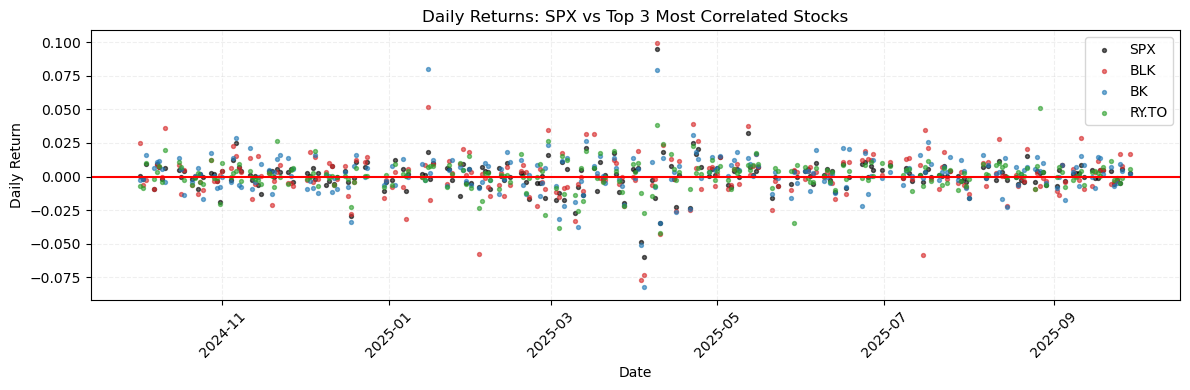

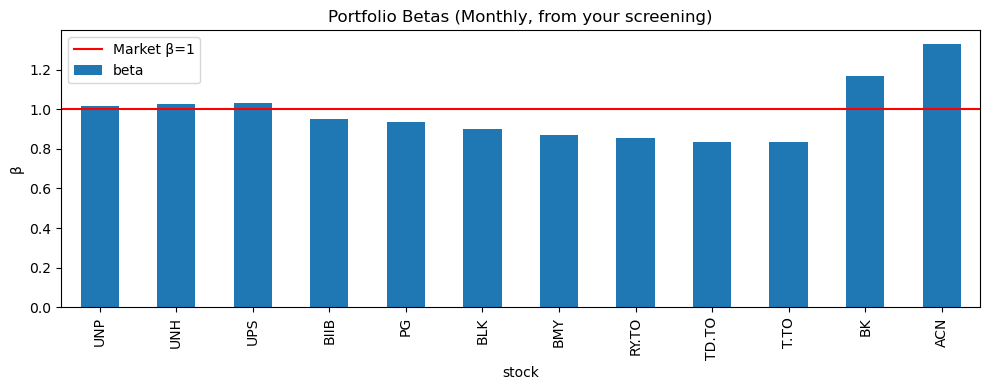

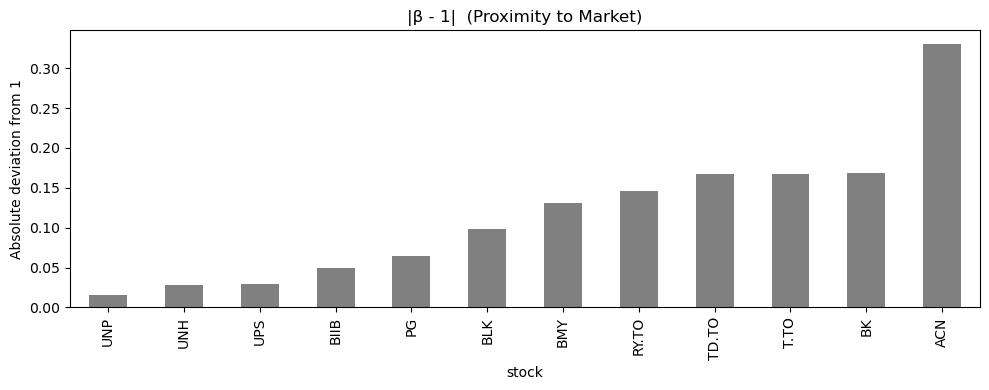

In [65]:
tickers = list(final_portfolio_stocks['stock'])
bench = '^GSPC'              # S&P 500
start_d, end_d = start, end

def get_close_df(tickers, start, end):
    # Return the aligned “Closing Price” DataFrame (columns = codes, rows = dates)
    frames = []
    for t in tickers:
        s_hist = yf.Ticker(t).history(start=start_d, end=end_d)
        s = s_hist['Close'].copy()
        s.name = t
        frames.append(s)
    df = pd.concat(frames, axis=1)
    df.index = pd.to_datetime(df.index.strftime("%Y-%m-%d"))
    return df

# 1) Daily Close
px_stk = get_close_df(tickers, start_d, end_d)

px_mkt_hist = yf.Ticker(bench).history(start=start_d, end=end_d)
px_mkt = px_mkt_hist['Close'].copy()
px_mkt.name = 'bench'
px_mkt.index = pd.to_datetime(px_mkt.index.strftime("%Y-%m-%d"))

# 2) Align and calculate daily returns
rets_stk = px_stk.pct_change(fill_method=None).dropna(how='all')
rets_mkt = px_mkt.pct_change(fill_method=None).dropna()

common_idx = rets_stk.index.intersection(rets_mkt.index)
rets_stk = rets_stk.loc[common_idx]
rets_mkt = rets_mkt.loc[common_idx]  # 现在是一个 Series

# 3) Correlation coefficient between each stock and the S&P 500.
corr_to_spx = rets_stk.apply(lambda s: s.corr(rets_mkt), axis=0).sort_values(ascending=False)
corr_df = corr_to_spx.to_frame('Corr_to_SPX')
corr_df.index.name = 'Ticker'

display(corr_df)

# Select the top 3 stocks with the highest correlation
top3 = corr_to_spx.head(3)
print("Top 3 tickers by corr to SPX:", list(top3.index))

spx_ret = rets_mkt.rename('SPX')
plot_df = pd.concat([spx_ret, rets_stk[top3.index]], axis=1).dropna()

plt.figure(figsize=(12, 4))

colors = ['black', 'tab:red', 'tab:blue', 'tab:green']
for col, c in zip(plot_df.columns, colors):
    plt.scatter(plot_df.index, plot_df[col], s=8, alpha=0.6, label=col, color=c)

plt.title('Daily Returns: SPX vs Top 3 Most Correlated Stocks')
plt.xlabel('Date')
plt.ylabel('Daily Return') 

plt.axhline(0, color='red', linewidth=1.5)
plt.xticks(rotation=45)
plt.grid(alpha=0.2, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# β and the histogram for “distance β=1”
beta_df = final_portfolio_stocks.set_index('stock')[['beta','difference']]

plt.figure(figsize=(10,4))
beta_df['beta'].plot(kind='bar')
plt.axhline(1.0, color='red', linewidth=1.5, label='Market β=1')
plt.title('Portfolio Betas (Monthly, from your screening)')
plt.ylabel('β')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
beta_df['difference'].plot(kind='bar', color='gray')
plt.title('|β - 1|  (Proximity to Market)')
plt.ylabel('Absolute deviation from 1'); plt.tight_layout(); plt.show()
